Economy component, Contruction of components

In [2]:
using Mimi # start by importing the Mimi package to your space

@defcomp grosseconomy begin
	YGROSS	= Variable(index=[time])	# Gross output
	K	= Variable(index=[time])	# Capital
	l	= Parameter(index=[time])	# Labor
	tfp	= Parameter(index=[time])	# Total factor productivity
	s	= Parameter(index=[time])	# Savings rate
	depk	= Parameter()			# Depreciation rate on capital - Note that it has no time index
	k0	= Parameter()			# Initial level of capital
	share	= Parameter()			# Capital share

	function run_timestep(p, v, d, t)
		# Define an equation for K
		if is_first(t)
			# Note the use of v. and p. to distinguish between variables and 
			# parameters
			v.K[t] 	= p.k0	
		else
			v.K[t] 	= (1 - p.depk)^5 * v.K[t-1] + v.YGROSS[t-1] * p.s[t-1] * 5
		end

		# Define an equation for YGROSS
		v.YGROSS[t] = p.tfp[t] * v.K[t]^p.share * p.l[t]^(1-p.share)
	end
end


Component for greenhouse gas emission

In [3]:
@defcomp emissions begin
	E	= Variable(index=[time])	# Total greenhouse gas emissions
	sigma	= Parameter(index=[time])	# Emissions output ratio
	YGROSS	= Parameter(index=[time])	# Gross output - Note that YGROSS is now a parameter

	function run_timestep(p, v, d, t)

	# Define an equation for E
	v.E[t] = p.YGROSS[t] * p.sigma[t]	# Note the p. in front of YGROSS
	end
end

Construct the model using Mimi

In [4]:

using Mimi

function construct_model()
	m = Model()

	set_dimension!(m, :time, collect(2015:5:2110))

	# Order matters here. If the emissions component were defined first, the model would not run.
	add_comp!(m, grosseconomy)  
	add_comp!(m, emissions)

	# Update parameters for the grosseconomy component
	update_param!(m, :grosseconomy, :l, [(1. + 0.015)^t *6404 for t in 1:20])
	update_param!(m, :grosseconomy, :tfp, [(1 + 0.065)^t * 3.57 for t in 1:20])
	update_param!(m, :grosseconomy, :s, ones(20).* 0.22)
	update_param!(m, :grosseconomy, :depk, 0.1)
	update_param!(m, :grosseconomy, :k0, 130.)
	update_param!(m, :grosseconomy, :share, 0.3)

	# Update parameters for the emissions component
	update_param!(m, :emissions, :sigma, [(1. - 0.05)^t *0.58 for t in 1:20])
	
	# connect parameters for the emissions component
	connect_param!(m, :emissions, :YGROSS, :grosseconomy, :YGROSS)  

	return m

end #end function

construct_model (generic function with 1 method)

Run the model

In [5]:
# Run model
m = construct_model()
run(m)

# Check model results
getdataframe(m, :emissions, :E) # or m[:emissions, :E_Global] to return just the Array

Row,time,E
,Int64,Float64?
1,2015,4211.09
2,2020,15079.5
3,2025,23922.3
4,2030,30255.8
5,2035,35175.7
6,2040,39293.0
7,2045,42947.7
8,2050,46344.9
9,2055,49617.2


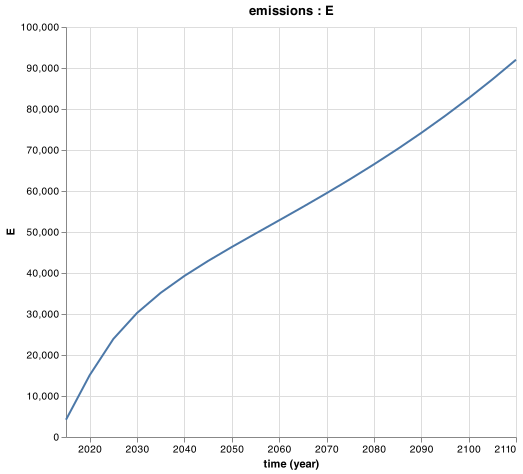

In [8]:
# Plot model results
Mimi.plot(m, :emissions, :E)

